In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import pickle
import joblib

In [2]:
# return monthly average and regional longitude, latitude
# extract and group each month data
# after calculate the anomaly, remove the outliers
def month_data_sst(anom, month):
    month_group = anom.groupby("time.month").groups # group into seasons, use groups to read each group
    month_index = month_group[month]
    month_anom = anom[month_index,:,:,:]
    #### THE THRESHOLD????
    #month_anom = xr.where((month_anom>5), 0, month_anom)
    return month_anom


# calculate normalized anomalies -- CESM
# climatology based on 1976 to 2005 
def nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1976", "2005")).load()
    #lons_xr = dataset['lon'] # from -12W to 36E
    #lats_xr = dataset['lat'] # from 35N to 73N
    rr_clm = ds_clm

    gb_clm = rr_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    prcp_anom = (gb - gb_clm.mean(dim="time")).groupby("time.month")/gb_clm.std(dim="time")

    return prcp_anom

In [3]:
def data_load_cesm_pdo(fn, start, end): 
    ds_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_xr = ds_xr.sel(time=slice(start, end)).load()
    # convert 0-360 to -180-180
    # How to extract the desired region? -- by calculation
    reg_lon_xr = ds_xr['nlon'] # from -40.375W to 75.375E
    reg_lat_xr = ds_xr['nlat'] # from 25.375N to 75.375N
    temp_xr = ds_xr['SST'].squeeze()
    #xr1 = temp_xr[:,:,149:206,177:285]
    xr1 = temp_xr[:,260:330,140:270]
    xr2 = temp_xr
    # time, lat, lon
    return xr1,xr2, reg_lat_xr, reg_lon_xr

In [4]:
# first calculate all the sst anomaly
import os
path = r'C:/Users/yzh086/OneDrive - University of Bergen/PhD_lit/PhD_lit/task1/Data/CESM1/sst'
filelist = os.listdir(path)

pathlist = []
for i in range(len(filelist)):
    temp = path + '/' + filelist[i]
    pathlist.append(temp)
    
fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

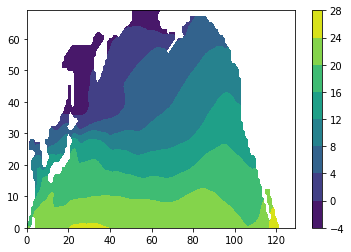

In [9]:
plt.contourf(temp_xr['SST'][1,0,260:330,140:270])
plt.colorbar()

In [11]:
temp_xr['SST'][1,0,260:330,140:270].TLAT[:,1]

<xarray.DataArray 'TLAT' (nlat: 70)>
array([23.34039645, 23.8577158 , 24.38501924, 24.92200352, 25.46827979,
       26.02337111, 26.58671161, 27.15764733, 27.73543924, 28.31926831,
       28.90824276, 29.50140744, 30.09775468, 30.69623785, 31.29616202,
       31.89735145, 32.49979096, 33.10347356, 33.70839165, 34.31453694,
       34.92190052, 35.53047277, 36.14024339, 36.75120138, 37.36333499,
       37.97663178, 38.5910785 , 39.20666121, 39.82336516, 40.44117481,
       41.06007385, 41.68004512, 42.30107067, 42.92313168, 43.5462085 ,
       44.17028059, 44.79532657, 45.42132415, 46.04825015, 46.67608047,
       47.30479006, 47.93435296, 48.56474224, 49.19593   , 49.82788739,
       50.46058454, 51.09399057, 51.72807357, 52.3628006 , 52.99813767,
       53.6340497 , 54.27050053, 54.90745285, 55.54486826, 56.18270717,
       56.82092879, 57.4594911 , 58.09835083, 58.73746345, 59.37678301,
       60.01626221, 60.65585229, 61.29550299, 61.93516241, 62.57477701,
       63.21429142, 63.85364842, 64.49278871, 65.1316508 , 65.77017083])
Coordinates:
    TLAT     (nlat) float64 23.34 23.86 24.39 24.92 ... 63.85 64.49 65.13 65.77
    TLONG    (nlat) float64 119.1 119.1 119.1 119.1 ... 116.7 116.5 116.4 116.2
    ULAT     (nlat) float64 23.6 24.12 24.65 25.2 ... 64.2 64.84 65.48 66.12
    ULONG    (nlat) float64 119.7 119.7 119.7 119.7 ... 117.2 117.1 116.9 116.8
    time     object 1920-02-01 00:00:00
    z_t      float32 500.0
Dimensions without coordinates: nlat
Attributes:
    long_name:  array of t-grid latitudes
    units:      degrees_north

In [12]:
temp_xr['SST'][1,0,260:330,140:270].TLONG[1]

<xarray.DataArray 'TLONG' (nlon: 130)>
array([117.99928509, 119.12734648, 120.25543598, 121.38355219,
       122.51169366, 123.63985897, 124.76804663, 125.89625519,
       127.02448314, 128.15272898, 129.2809912 , 130.40926828,
       131.53755867, 132.66586082, 133.7941732 , 134.92249423,
       136.05082235, 137.179156  , 138.30749358, 139.43582851,
       140.56416924, 141.69251421, 142.8208518 , 143.94918544,
       145.07751356, 146.20583459, 147.33414697, 148.46244913,
       149.59073951, 150.71901659, 151.84727881, 152.97552465,
       154.10375261, 155.23196116, 156.36014883, 157.48831413,
       158.61645561, 159.74457181, 160.87266131, 162.0007227 ,
       163.12875459, 164.25675559, 165.38472437, 166.51265957,
       167.6405599 , 168.76842407, 169.89625081, 171.02403888,
       172.15178707, 173.27949418, 174.40715906, 175.53478056,
       176.66235758, 177.78988903, 178.91737387, 180.04481106,
       181.17219962, 182.29953858, 183.42682701, 184.554064  ,
       185.68124868, 186.80838021, 187.93545779, 189.06248064,
       190.18944802, 191.31635921, 192.44321354, 193.57001036,
       194.69674906, 195.82342906, 196.95004983, 198.07661084,
       199.20311162, 200.32955172, 201.45593074, 202.58224829,
       203.70850404, 204.83469766, 205.96082888, 207.08689746,
       208.21290317, 209.33884585, 210.46472534, 211.59054152,
       212.7162943 , 213.84198364, 214.96760951, 216.09317191,
       217.21867088, 218.34410649, 219.46947884, 220.59478804,
       221.72003425, 222.84521765, 223.97033845, 225.09539688,
       226.2203932 , 227.34532771, 228.4702007 , 229.59501252,
       230.71976353, 231.84445411, 232.96908466, 234.09365563,
       235.21816745, 236.3426206 , 237.46701558, 238.59135288,
       239.71563305, 240.83985664, 241.96402421, 243.08813635,
       244.21219366, 245.33619675, 246.46014627, 247.58404286,
       248.70788718, 249.8316799 , 250.95542173, 252.07911335,
       253.20275548, 254.32634885, 255.44989418, 256.57339224,
       257.69684376, 258.82024951, 259.94361027, 261.06692681,
       262.19019993, 263.3134304 ])
Coordinates:
    TLAT     (nlon) float64 23.85 23.86 23.87 23.87 ... 22.28 22.26 22.24 22.23
    TLONG    (nlon) float64 118.0 119.1 120.3 121.4 ... 259.9 261.1 262.2 263.3
    ULAT     (nlon) float64 24.11 24.12 24.13 24.14 ... 22.5 22.48 22.46 22.44
    ULONG    (nlon) float64 118.6 119.7 120.8 121.9 ... 260.5 261.6 262.8 263.9
    time     object 1920-02-01 00:00:00
    z_t      float32 500.0
Dimensions without coordinates: nlon
Attributes:
    long_name:  array of t-grid longitudes
    units:      degrees_east

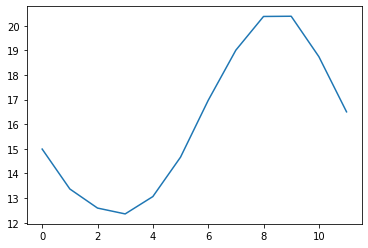

In [25]:
plt.plot(temp_xr['SST'][:12,0,260:330,140:270].mean(axis=1).mean(axis=1))

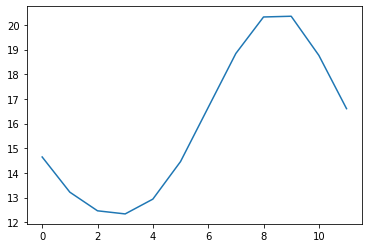

In [24]:
plt.plot(temp_xr['SST'][:,0,260:330,140:270].groupby("time.month").mean().mean(axis=1).mean(axis=1))

In [5]:
# preprocess SST -- all data together
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## change parameter for different region ##

fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

sst_xr, sst_global, reg_lat_xr, reg_lon_xr = data_load_cesm_pdo(fn1, '192002', '200601')

In [6]:
# global spatial averaged sst anomaly
def global_nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1976", "2005")).load()
    #lons_xr = dataset['lon'] # from -12W to 36E
    #lats_xr = dataset['lat'] # from 35N to 73N
    rr_clm = ds_clm

    gb_clm = rr_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    anom = (gb - gb_clm.mean(dim="time")).groupby("time.month")/gb_clm.std(dim="time")
    # no normalization for calculating the nino index  # normalized

    return anom

In [7]:
# calculate anomaly
sst_anom = nor_anom(sst_xr)

# detrend the time series at each grid point
#sst_danom = detrend_dim(sst_anom, 'time', deg=1)

global_anom = global_nor_anom(sst_global)
# spatially averaged mean global SST anomaly time series
global_anom_mean = global_anom.mean(axis=1).mean(axis=1)
sst_danom = sst_anom - global_anom_mean
# extract and group each season data
#anom_ensemble = sst_anom
anom_original = sst_danom

data = np.squeeze(sst_danom.values) # remove dimension = 1
time = temp_xr.time
tlat = sst_anom.TLAT
tlong = sst_anom.TLONG
pdo_ensemble = xr.DataArray(data, 
                    coords={'time':time, 
                            'TLAT':(("nlat", "nlon"), np.array(tlat)),
                            'TLONG':(("nlat", "nlon"), np.array(tlong))},  # format for multiple dimensions
                    dims=['time', 'nlat', 'nlon'])
#pdo_ensemble = anom_ensemble.mean(axis=1).mean(axis=1)

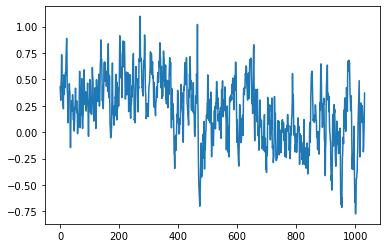

In [46]:
plt.plot(pdo_ensemble)

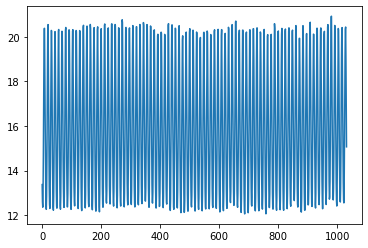

In [41]:
plt.plot(sst_xr.mean(axis=1).mean(axis=1))

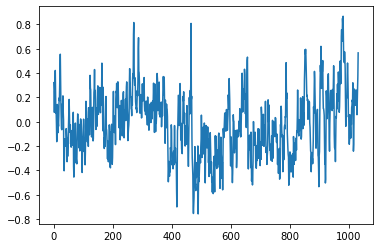

In [40]:
plt.plot(sst_anom.mean(axis=1).mean(axis=1))

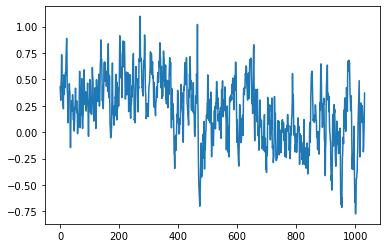

In [39]:
plt.plot(sst_danom.mean(axis=1).mean(axis=1))

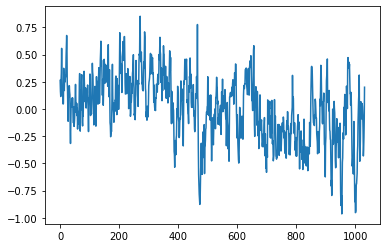

In [38]:
plt.plot(sst_decycle.mean(axis=1).mean(axis=1))

In [8]:
##### ensemble #####
for i in range(1,len(filelist)):

    fn1 = pathlist[i]
    sst_xr, sst_global, reg_lat_xr, reg_lon_xr = data_load_cesm_pdo(fn1, '192002', '200601')
    
    global_anom = global_nor_anom(sst_global)
    # spatially averaged mean global SST anomaly time series
    global_anom_mean = global_anom.mean(axis=1).mean(axis=1)
    # calculate anomaly
    sst_anom = nor_anom(sst_xr)

    sst_danom = sst_anom - global_anom_mean
    # extract and group each season data
    #anom_ensemble = sst_anom
    anom_original = sst_danom

    data = np.squeeze(sst_danom.values) # remove dimension = 1
    time = temp_xr.time
    tlat = sst_anom.TLAT
    tlong = sst_anom.TLONG
    pdo_gb_temp = xr.DataArray(data, 
                        coords={'time':time, 
                                      'TLAT':(("nlat", "nlon"), np.array(tlat)),
                                      'TLONG':(("nlat", "nlon"), np.array(tlong))}, 
                        dims=['time', 'nlat', 'nlon'])

    #amo_gb_temp = anom_gb_temp.mean(axis=1).mean(axis=1)
    pdo_ensemble = xr.concat([pdo_ensemble,pdo_gb_temp], dim='time')

In [9]:
### save and load as netcdf ###
pdo_ensemble.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo.nc'
                        )

In [12]:
pdo_ensemble

<xarray.DataArray (time: 41280, nlat: 70, nlon: 130)>
array([[[ 0.89205265,  1.0273678 ,         nan, ...,         nan,
                 nan, -1.423516  ],
        [ 0.5641236 ,  0.6881997 ,  0.6945362 , ...,         nan,
                 nan, -1.4461076 ],
        [        nan,  0.55871475,  0.56011724, ...,         nan,
                 nan, -1.4605954 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.92384595,  0.95905167,         nan, ...,         nan,
                 nan, -1.4724677 ],
        [ 0.7343671 ,  0.7292167 ,  0.64583796, ...,         nan,
                 nan, -1.5072364 ],
        [        nan,  0.6074772 ,  0.5559594 , ...,         nan,
                 nan, -1.5312948 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.5214109 , -0.5667186 ,         nan, ...,         nan,
                 nan, -0.7485302 ],
        [-0.45821935, -0.4822352 , -0.5677617 , ...,         nan,
                 nan, -0.77527416],
        [        nan, -0.4015375 , -0.45460483, ...,         nan,
                 nan, -0.80971336],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
    TLAT     (time, nlat, nlon) float64 23.33 23.34 23.35 ... 54.71 54.58 54.46
    TLONG    (time, nlat, nlon) float64 118.0 119.1 120.3 ... 265.0 266.1 267.1
Dimensions without coordinates: nlat, nlon

In [52]:
##### save the data -- no need to run the previous again #####

df = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_pdo.txt' 
          ,'wb')
pickle.dump(pdo_ensemble, df)
df.close()

In [5]:
##### open the file for next use #####

df2 = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_pdo.txt' 
          ,'rb')
ensemble = pickle.load(df2)
df2.close()

In [13]:
##### preprocessing wrong data ####
pdo_ensemble[33243] = pdo_ensemble[33231]

In [14]:
meantlat = np.mean(pdo_ensemble.TLAT.values[0], axis = 1)

In [15]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
#meantlat = np.mean(ensemble.lat.values, axis = 1)
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(70, 1) ## depends on the shape of region

solver = Eof(pdo_ensemble, weights=wgts)

In [16]:
eof_en = solver.eofs(neofs=5)
pc_en  = solver.pcs(npcs=5, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

In [17]:
eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo_eof.nc')
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo_pc.nc')
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo_var.nc')
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo_lam.nc')

In [18]:
pc_en[:,1]

<xarray.DataArray 'pcs' (time: 41280)>
array([ 8.744034 , 10.969793 ,  7.2977896, ..., 17.87941  , 27.826271 ,
       31.414974 ], dtype=float32)
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
    mode     int32 1

In [17]:
##### save data #####
import joblib
joblib.dump(eof_en, r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\pdo_eof.pkl' 
            ,compress=9)
joblib.dump(pc_en, r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\pdo_pc.pkl'
            ,compress=9)
joblib.dump(varfrac_en, r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\pdo_varfrac.pkl'
            ,compress=9)
joblib.dump(lambdas_en, r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\pdo_lambdas.pkl'
            ,compress=9)

['C:\\Users\\yzh086\\OneDrive - University of Bergen\\PhD_lit\\PhD_lit\\task1\\processed_data\\pdo_lambdas.pkl']

In [6]:
##### open data #####
import joblib

eof_en = joblib.load(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo_eof.pkl')
pc_en = joblib.load(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo_pc.pkl')
varfrac_en = joblib.load(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo_varfrac.pkl')
lambdas_en = joblib.load(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo_lambdas.pkl')

In [7]:
eof_en

<xarray.DataArray 'eofs' (mode: 5, nlat: 70, nlon: 130)>
array([[[-0.0079593 , -0.00807227,         nan, ...,         nan,
                 nan, -0.00671589],
        [-0.00713183, -0.00711915, -0.00692879, ...,         nan,
                 nan, -0.00673162],
        [        nan, -0.00674264, -0.00672945, ...,         nan,
                 nan, -0.00678269],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.00831261, -0.00882396,         nan, ...,         nan,
                 nan,  0.0071857 ],
        [-0.00728902, -0.00736353, -0.00669258, ...,         nan,
                 nan,  0.00706373],
        [        nan, -0.00652384, -0.00629901, ...,         nan,
                 nan,  0.00697424],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.01386351,  0.01469932,         nan, ...,         nan,
                 nan,  0.0071725 ],
        [ 0.01358211,  0.01438991,  0.01495833, ...,         nan,
                 nan,  0.00676351],
        [        nan,  0.0142851 ,  0.01478564, ...,         nan,
                 nan,  0.00635236],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * mode     (mode) int32 0 1 2 3 4
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67 68 69
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 122 123 124 125 126 127 128 129
Attributes:
    long_name:  empirical_orthogonal_functions

In [8]:
### re-apply for new coordinate since it is not equally placed ###
### this should be changed by different region ###
new_lat = np.linspace(23,65,70) # -20 to 20
new_long = np.linspace(118,263,130) # 110 E to 75 W

In [ ]:
##### finally plot #####

#fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),dpi =300)
# if on the west sphere, change the central longitude

fig, axs = plt.subplots(2,2, figsize=(12,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)),dpi =300)

fig = plt.gcf()

#title1 = '%s_cluster' % (season)

for ax, i in zip(axs.ravel(), range(4)):

    title2 = 'EOF%s(%s%%)' % (i+1, int(varfrac_en[i]*100))
    # tim
    data = eof_en[i]
    # Add cyclic point to data
    #data=mean_anom_djf_cluster1
    data, lons = add_cyclic_point(data, coord=new_long)
    lat = new_lat
    # Make a filled contour plot
    # Add coastlines
    ax.coastlines()

    # mask the LAND part with white color
    ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

    cs=ax.contourf(lons, new_lat, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',#levels = np.linspace(-0.01,0.0,7),
                   extend='both') # (lat, lon)

    # Define the xticks for longitude

    ax.set_xticks(np.arange(-90,90,15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    #plt.title(title2, fontsize = 18)
    ax.set_title(title2, fontsize = 22)

    ax.set_yticks(np.arange(-20,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1, top = 0.95, hspace =0.2, wspace=.025)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.02, 0.9,0.02]) # left&right, bottom, size, size
#plt.colorbar(cax=cax)
#cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)
    
    
fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\eof\slp\eof_slp_test.png')

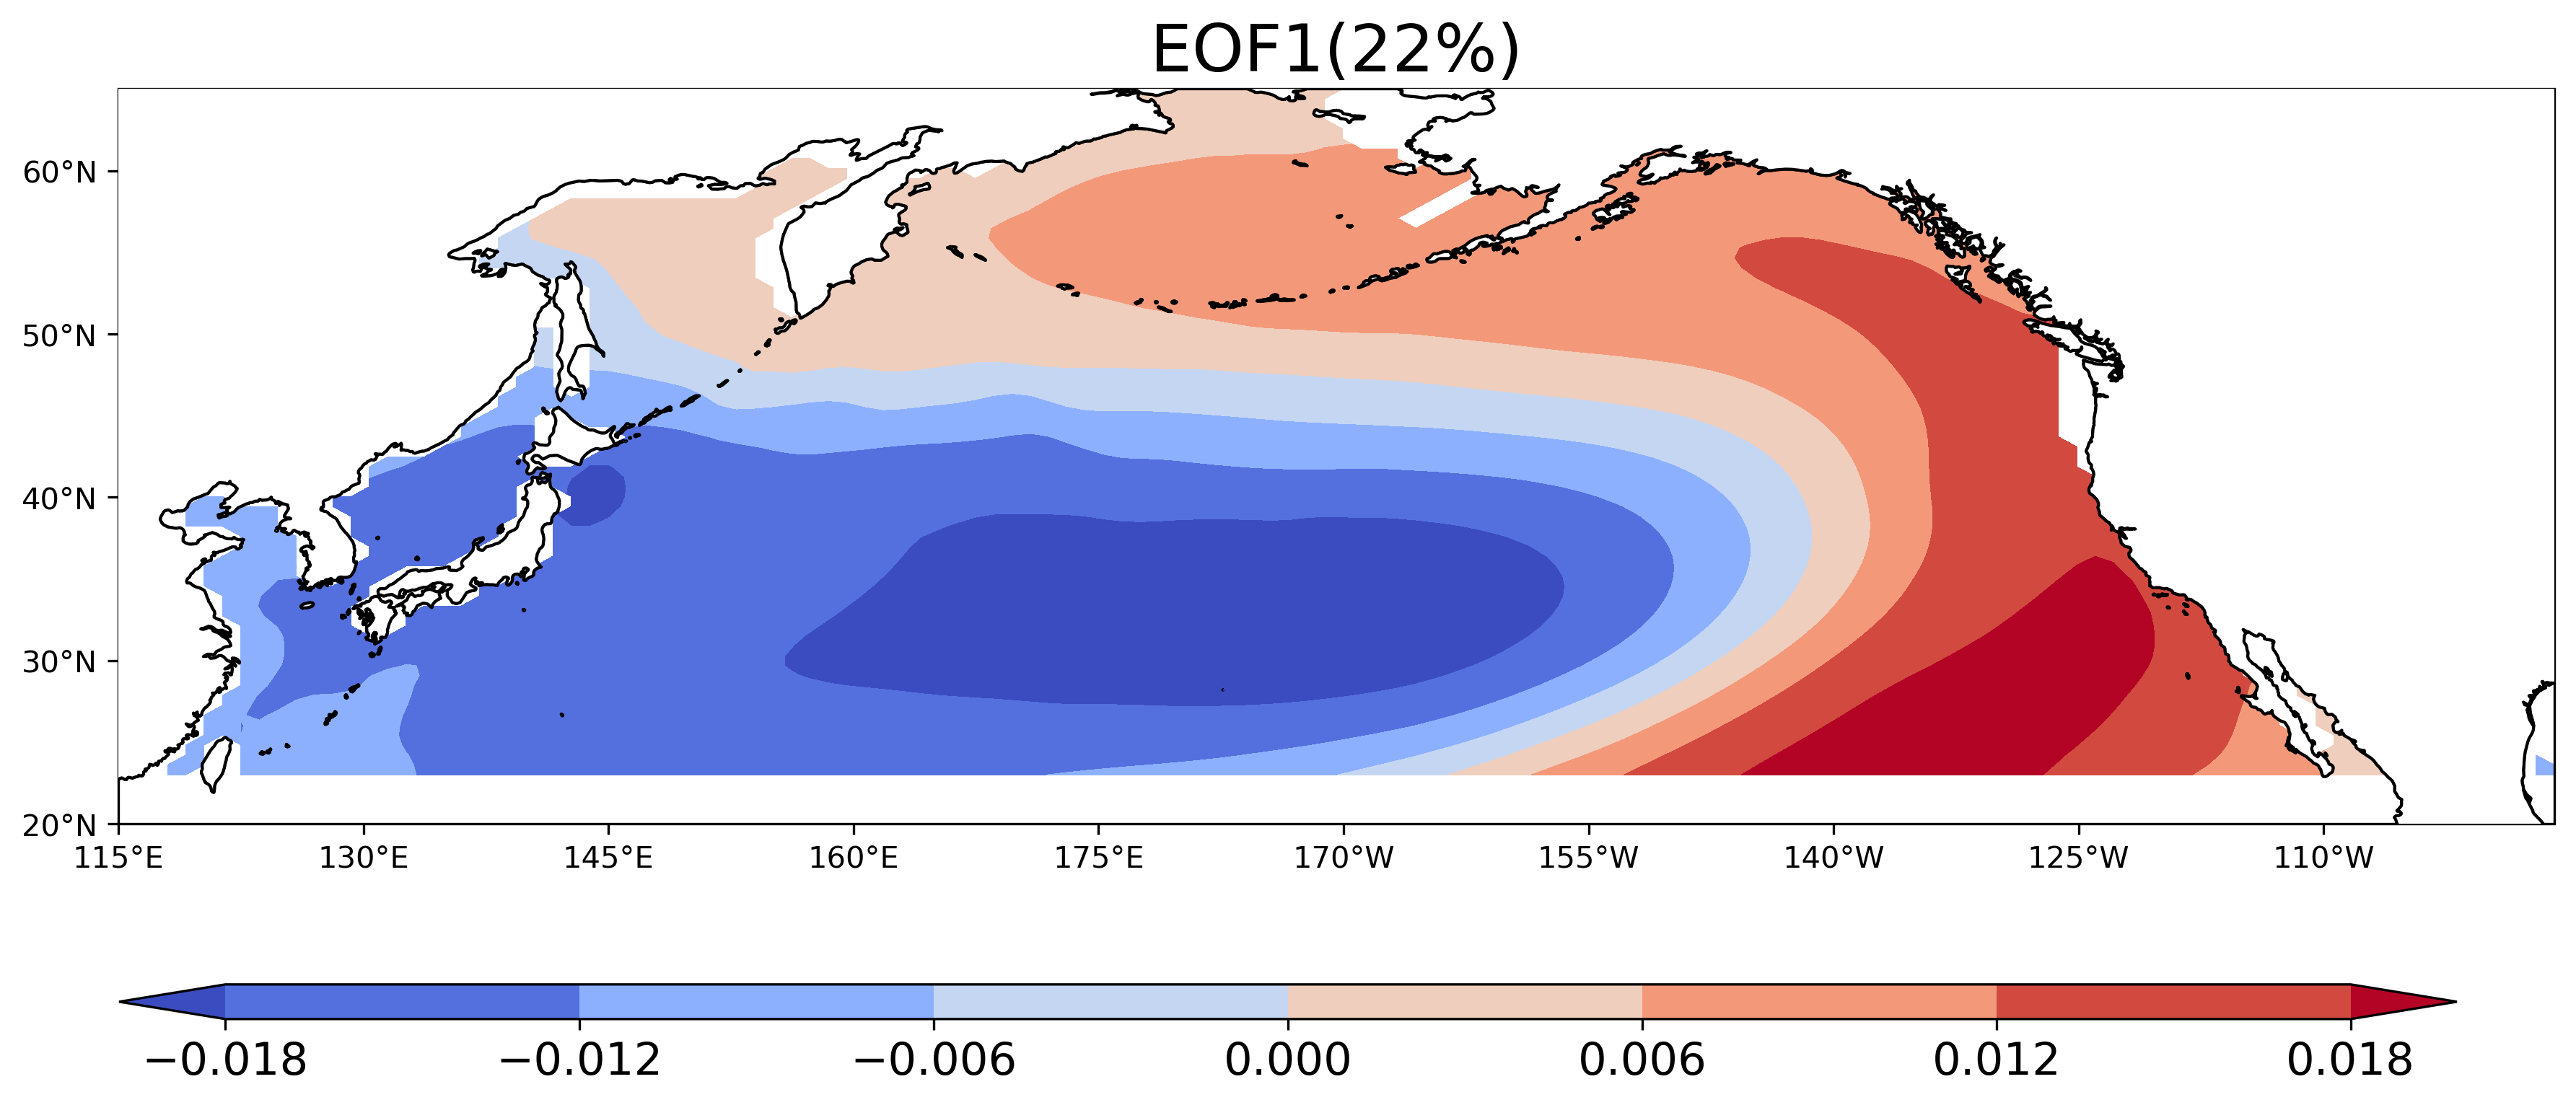

In [12]:
##### finally plot #####

#fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),dpi =300)
# if on the west sphere, change the central longitude

fig, ax = plt.subplots(figsize=(12,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),dpi =300)

fig = plt.gcf()

#title1 = '%s_cluster' % (season)

#for ax, i in zip(axs.ravel(), range(4)):

title2 = 'EOF%s(%s%%)' % (0+1, int(varfrac_en[0]*100))
# tim
data = eof_en[0]
# Add cyclic point to data
#data=mean_anom_djf_cluster1
data, lons = add_cyclic_point(data, coord=new_long)
lat = new_lat
# Make a filled contour plot
# Add coastlines
ax.coastlines()

# mask the LAND part with white color
ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

cs=ax.contourf(lons, new_lat, data,
            transform = ccrs.PlateCarree(),cmap='coolwarm',#levels = np.linspace(-0.01,0.0,7),
               extend='both') # (lat, lon)

# Define the xticks for longitude

ax.set_xticks(np.arange(115,265,15), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
#plt.title(title2, fontsize = 18)
ax.set_title(title2, fontsize = 22)

ax.set_yticks(np.arange(20,70,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1, top = 0.95, hspace =0.2, wspace=.025)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.2, 0.9,0.02]) # left&right, bottom, size, size
#plt.colorbar(cax=cax)
#cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)
    
    
fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo.png')

In [13]:
pc_en

<xarray.DataArray 'pcs' (time: 41280, mode: 5)>
array([[ 46.28988  ,   8.744034 , -30.635592 ,   6.9418087,  17.399187 ],
       [ 30.909548 ,  10.969793 , -27.453094 ,  -4.4816785,  11.5908575],
       [ 27.643345 ,   7.2977896, -22.045351 ,  -3.0028872,   3.4523869],
       ...,
       [ 11.314503 ,  17.87941  ,  -6.4381905, -12.161909 ,  -4.538636 ],
       [ -7.2315345,  27.826271 ,   1.8608507, -13.383072 , -22.502861 ],
       [ 10.773824 ,  31.414974 ,   4.035588 , -13.013953 , -27.505213 ]],
      dtype=float32)
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
  * mode     (mode) int32 0 1 2 3 4

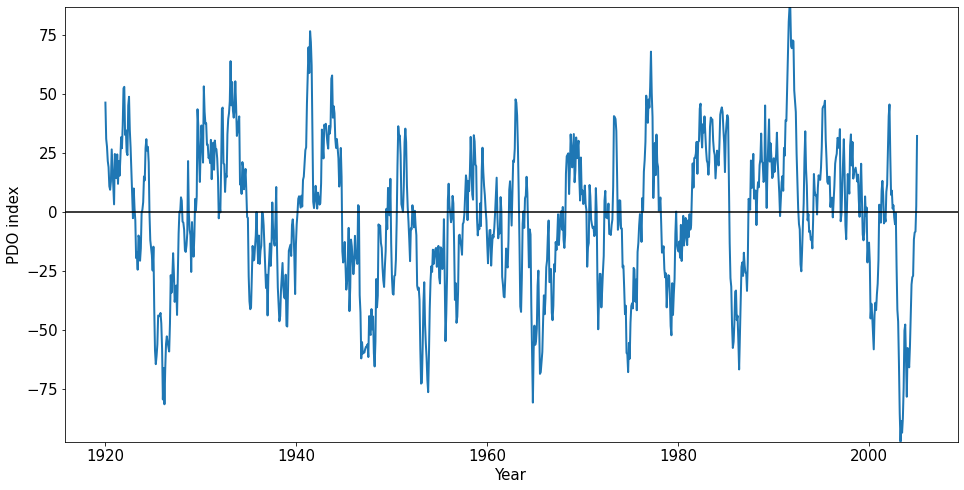

In [14]:
fig = plt.subplots(figsize=(16,8))
fig = plt.gcf()
days = np.linspace(1920,2005,1032)
plt.plot(days, pc_en[:1032,0], linewidth=2)
plt.axhline(0, color='k')
plt.xlabel('Year',fontsize = 15)
plt.ylabel('PDO index',fontsize = 15)   
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.ylim(np.min(pc_en[:1032,0]-0.1), np.max(pc_en[:1032,0]+0.1))

fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\PDO\pdo_pc.png')